## Purpose of this notebook

Explain what collocation analysis does.

...and how it is a tool, and what it may be good for, and what it is probably not good enough for.

In [1]:
# For local installs you can install the package once.   In colab you get a disposable environment and will have to start with this install each time. 
#!pip --quiet install https://github.com/knobs-dials/wetsuite-dev/archive/refs/heads/main.zip

In [8]:
import re
import random

import bs4  # BeautifulSoup is a handy way of scraping some text from HTML or XML

import wetsuite.helpers.koop_parse
import wetsuite.helpers.etree
import wetsuite.helpers.net
import wetsuite.helpers.strings
import wetsuite.helpers.collocation
import wetsuite.helpers.notebook
import wetsuite.helpers.spacy
import wetsuite.datasets

Fetch Burgerlijk wetboek 7 from KOOP respositories, in XML form.

At ~60k words this you may consider this fairly large, yet for this kind of analysis it is fairly small.

But we get the answer quickly, so we can play with the various parameters.

...which we want in a demo because as we will find out,
this whole concepts is somewhat finicky,
in that there is no zone with best results because we never really specified 
what kind of things we find more interesting than others.


In [9]:
bwb7_xml  = wetsuite.helpers.net.download( 'https://repository.officiele-overheidspublicaties.nl/bwb/BWBR0005290/2008-03-26_0/xml/BWBR0005290_2008-03-26_0.xml' )
bwb7_soup = bs4.BeautifulSoup( bwb7_xml ) # makes it easier to pick things out of that XML
sents     = []
for al in bwb7_soup.select('lid al'):
    sents.append(  ' '.join( al.find_all(text=True) )  )

parameters include
 - ***n-gram lengths to include*** - you generally don't want very long, because the more text you process, 
   the more entries there are with just one count  (frankly a problem with almost any n-gram based analysis)
   We can cheat in the following example, again because there is not a lot of text
 - what we call ***connectors*** - does not enter n-gram sequences with one of these words at the _edge_, but accepts them inside, 
   used as a makeshift reduction "got a phrase in the middle", and also keeps down the unique n-gram count (memory use)
   - CONSIDER: let us refuse only at the end of a sequence
 - ***minimum count*** - removes some things that would score well just because the combo happens once or twice
 - ***scoring method*** on top of the basic counting statistics (mostly trying to get the numbers on a more reasonable, readable scale)

In [5]:
connectors = 'De de een het  dat die dit deze  van voor met in op bij om na   en of   is   aan  ook   je ik we hij    door kan zal dan als tot lid te heeft niet worden wordt waarin'.split()
gramlens   = (2,3,4,5,6,7,8)  # we can get away with larger n-grams because this is a fairly small text
mincount   = 10               # remove n-gram sequences that didn't occur very much, for cleaner results
showtop    = 500

# do the calculation
coll = wetsuite.helpers.collocation.Collocation( connectors=connectors )
for sent in sents: # feed in text
    coll.consume_tokens( wetsuite.helpers.strings.simple_tokenize(sent), gramlens=gramlens )
coll.cleanup_ngrams(mincount=mincount) 
print( "Scoring, showing top %d\n"%showtop)
scores = coll.score_ngrams()

# show the result
print( ' %9s   %55s    %12s %20s'%( 'score', 'n-gram', 'n-gram count', 'individual counts' ) )
for strtup, score,  tup_count, uni_counts in scores[-showtop:]:
    print( ' %9.3f   %55s    %12s %30s=%d'%(score, ' '.join(strtup),   tup_count, '*'.join(str(n) for n in uni_counts), wetsuite.helpers.collocation.product(uni_counts)) )

Scoring, showing top 500

     score                                                    n-gram    n-gram count    individual counts
     0.000                  handelt in de uitoefening van een beroep              14   17*1437*5847*57*3537*1759*59=2988591451947501327
     0.000                                 ten nadele van de huurder              10           273*57*3537*5847*188=60501132707652
     0.000                               ten nadele van de werknemer              17           273*57*3537*5847*243=78200932169997
     0.001                     uitoefening van een beroep of bedrijf              20        57*3537*1759*59*1157*60=1452487407525180
     0.001                                     nadele van de huurder              10               57*3537*5847*188=221615870724
     0.001                                       bedoeld in de leden              12              308*1437*5847*118=305367339816
     0.001        arbeidsovereenkomst of bij regeling door of namens           

## Now with more text

In [ ]:
# Get a bunch more text

# while we're at it, get a spacy model to split sentences, 
# which should reduce the amount of across-sentence-boundary nonsense
# probably doesn't win a lot, but it's simple enough to do

paragraphs  = []
for bwbid, text in wetsuite.datasets.load('bwb-mostrecent-text').data.random_sample(12500):
    paragraphs.extend( re.split(r'[\s]{2,}', text) )


coll = wetsuite.helpers.collocation.Collocation( connectors=connectors )

for paragraph in wetsuite.helpers.notebook.ProgressBar(paragraphs, description='splitting sentences'):
    if len(paragraph) >= 1000000: # spacy refuses (without you upping the limit) for GPU memory reasons
        continue
    sents = wetsuite.helpers.spacy.sentence_split( paragraph, as_plain_sents=True )
    for sent in sents:
        toks = wetsuite.helpers.strings.simple_tokenize(sent)
        coll.consume_tokens( toks, gramlens=(2,3,4,5) )

In [42]:
print( "Cleanup")
print( '    before:', coll.counts() )
coll.cleanup_ngrams(mincount=8)
print( '     after:', coll.counts() )

Cleanup
    before: {'from_tokens': 18557187, 'unigrams': 184788, 'ngrams': 10317722}
     after: {'from_tokens': 18557187, 'unigrams': 184788, 'ngrams': 305139}


In [43]:
top = 2000
print( "Scoring, showing top %d\n"%top)
scores = coll.score_ngrams( )
print( ' %9s   %55s    %12s %20s'%('score', 'n-gram', 'n-gram count', 'individual counts') )
for strtup, score,  tup_count, uni_counts in scores[-top:]:
    print( ' %9.3f   %55s    %12s %20s=%d'%(score, ' '.join(strtup),   tup_count, '*'.join(str(n) for n in uni_counts), wetsuite.helpers.collocation.product(uni_counts)) )

Scoring, showing top 2000

     score                                                    n-gram    n-gram count    individual counts
   171.261                polycyclische aromatische koolwaterstoffen              49            51*71*166=601086
   171.304                    preconcurrentieel ontwikkelingsproject              29                62*97=6014
   171.500                                  dynamisch aankoopsysteem              14                56*25=1400
   171.709                     Helicopter landing officer Genormeerd              10          17*68*42*18=873936
   171.721                                 basisregistratie kadaster             169              705*289=203745
   171.742                                      Beroepsopleiding VAM              16                22*83=1826
   171.762                                                   St Goar              12                79*13=1027
   171.818                    arbeidsondersteuning jonggehandicapten              36

# THE OTHER ONE


In [ ]:
# A fancier tokenizer (e.g. spacy's) would likely give cleaner results 
from spacy.tokenizer import Tokenizer
from spacy.lang.nl import Dutch
dutch = Dutch()
tokenizer = Tokenizer(dutch.vocab)
def nl_tokenize(nl_sent):
     doc = tokenizer( nl_sent.rstrip() )
     return list(tok.text for tok in doc)
 
# for a faster but rougher test you could avoid that big dependency by using something like simple_tokenize(text)


In [7]:
kv   = wetsuite.datasets.load('tweedekamer-kamervragen-struc')

coll = wetsuite.helpers.collocation.Collocation( connectors=connectors )

# Get a bunch more text

# while we're at it, get a spacy model to split sentences, 
# which should reduce the amount of across-sentence-boundary nonsense
# probably doesn't win a lot, but it's simple enough to do

paragraphs  = []

for kv_id, kv_details in wetsuite.helpers.notebook.ProgressBar( kv.data.random_sample(1000) ):
    vraagdata = kv_details['vraagdata']

    for number in vraagdata:
        try:
            vraag   , _ = vraagdata[number]['vraag']
            antwoord, _ = vraagdata[number]['antwoord']
        except KeyError: # TODO: fix
            continue

        for text in vraag, antwoord:
            for paragraph in re.split(r'[\s]{2,}', text):
                for sentence in wetsuite.helpers.spacy.sentence_split( paragraph, as_plain_sents=True ):
                    coll.consume_tokens(  wetsuite.helpers.strings.simple_tokenize( sentence ), gramlens=(2,3,4,5)  )



  0%|          | 0/1000 [00:00<?, ?it/s]

2024-03-12 00:17:26.644176: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 00:17:28.702063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-12 00:17:28.706337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-12 00:17:28.706463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [8]:
print( coll.counts() )
#coll.cleanup_unigrams(mincount=2)
coll.cleanup_ngrams(mincount=5)
print( coll.counts() )

{'from_tokens': 865696, 'unigrams': 39099, 'ngrams': 859482}
{'from_tokens': 865696, 'unigrams': 39099, 'ngrams': 10293}


In [9]:
top = 2000
print( "Scoring, showing top %d\n"%top)
scores = coll.score_ngrams( )
print( ' %9s   %55s    %12s %20s'%('score', 'n-gram', 'n-gram count', 'individual counts') )
for strtup, score,  tup_count, uni_counts in scores[-top:]:
    print( ' %9.3f   %55s    %12s %20s=%d'%(score, ' '.join(strtup),   tup_count, '*'.join(str(n) for n in uni_counts), wetsuite.helpers.collocation.product(uni_counts)) )

Scoring, showing top 2000

     score                                                    n-gram    n-gram count    individual counts
     5.495                                             december 2015              20              247*361=89167
     5.503                                  voorgeschreven procedure               5               35*159=5565
     5.508                                                12 maanden              10              160*139=22240
     5.513                                              hard gewerkt               5               55*101=5555
     5.516                                                stap gezet               6               65*123=7995
     5.517                                                  keer per              19               96*835=80160
     5.520                                          wettelijke taken              10               274*81=22194
     5.537                                          nader informeren              16  

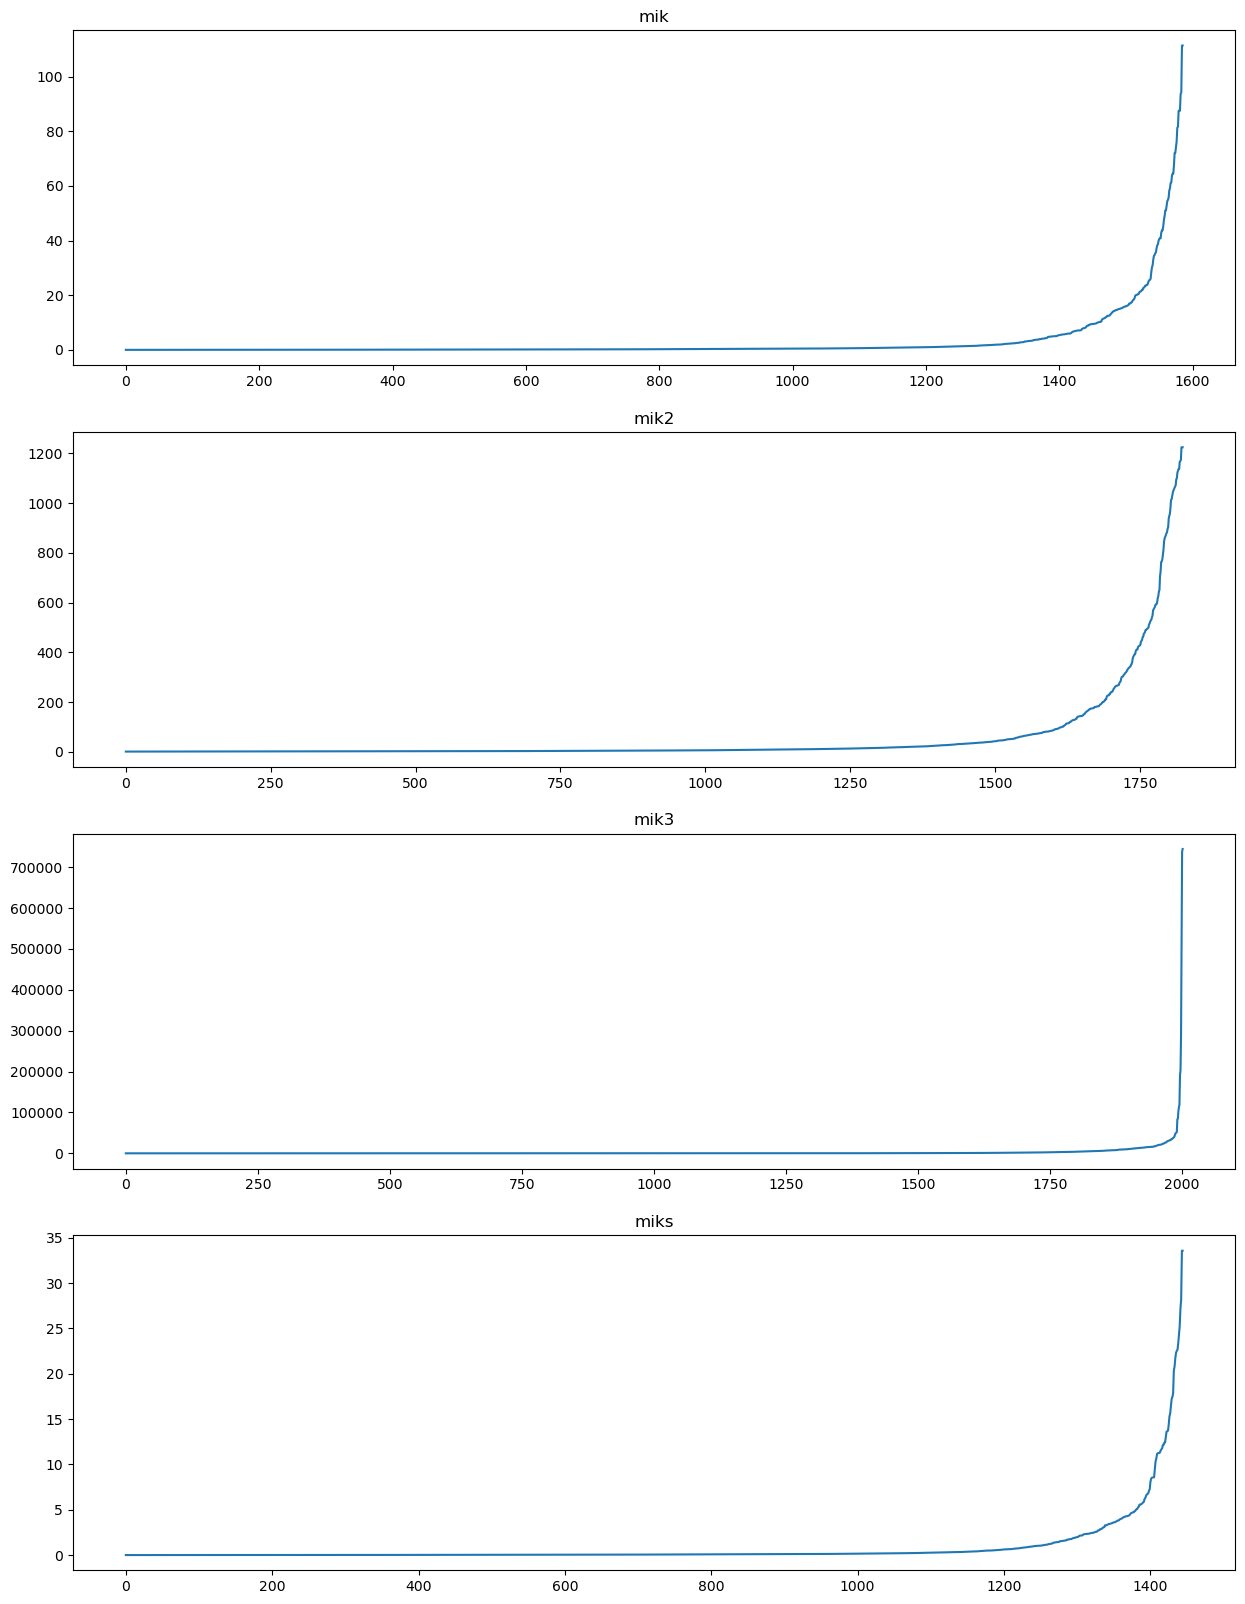

In [10]:
import numpy, matplotlib.pyplot

fig, axes = matplotlib.pyplot.subplots(4,1, figsize=(15,20))

for ai, method in enumerate( ('mik', 'mik2', 'mik3') ):
    scored_grams = coll.score_ngrams( method=method, sort=True )[-5000:]

    if 0:
        tup_counts = list(tup_count                                           for strtup, score,  tup_count, uni_counts in scored_grams)
        uniprod    = list( wetsuite.phrases.collocation.product(uni_counts)   for strtup, score,  tup_count, uni_counts in scored_grams)

        axes[ai].plot( tup_counts,                                                 c='r', label='tup_count')
        axes[ai].set_ylim(0,numpy.percentile(tup_counts,90))
        axes[ai].set_title(method)
        y2 = axes[ai].twinx()
        y2.plot( uniprod, c='b', label='uniprod')
        y2.set_ylim=(0,numpy.percentile(uniprod,50))
        continue

    if 0:
        axes[ai].hist( list(tup_count for strtup, score,  tup_count, uni_counts in scored_grams   if tup_count>10),   align='mid', rwidth=0.9, range=(0,100), bins=100 )
    
    if 1:   
        axes[ai].plot( list(score for strtup, score,  tup_count, uni_counts in scored_grams   if tup_count>10) )
        axes[ai].set_title( method )

In [ ]:
## gensim.phrases example

In [ ]:
# train
from gensim.models.phrases import Phrases
nl_connectors = frozenset( 'de een   van voor met in op bij   en of'.split() )
phrase_model = Phrases(train_sents_tok, min_count=1, threshold=0.4, connector_words=nl_connectors, scoring='npmi', delimiter='\u00a0')


In [ ]:
# choose a smaller subset of sentences and see which phrases are _commonly_ detected
import collections
count=collections.defaultdict(int)

#test_sents = random.sample(sents, 100000)
test_sents = sents

for test_sent in test_sents:
    sent_tok = sent_tokenize( test_sent )
    result = phrase_model[sent_tok]
    for tok in result:
        if '\u00a0' in tok:
            count[tok] += 1

for tok, cnt in sorted( count.items(), key=lambda x:x[1], reverse=True )[:1000]:
    print( '%5d  %20s '%(cnt, tok) )
    if cnt==1:
        break

In [ ]:
test_sents = [sent_tokenize(sent)   for sent in random.sample(sents, 1000000)]

for phrase, score in sorted( phrase_model.find_phrases( test_sents ).items(), key=lambda x:x[1], reverse=True)[:1000]:
    w1,w2 = phrase.split('\u00a0',1)
    print('%5.2f  %20s %-20s'%(score,w1,w2))



## NLTK example

In [ ]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

from nltk.corpus import stopwords

flat = []
for toksent in train_sents_tok:
    flat.extend( toksent )

top = 1000
window_size = 6

bigram_measures = BigramAssocMeasures()
col_finder = BigramCollocationFinder.from_words(flat, window_size=window_size)
col_finder.apply_word_filter(lambda w: len(w) < 2 or w.lower() in stopwords.words('dutch'))
col_finder.apply_freq_filter(3)

In [ ]:
# calculate the top results by T-score
#   possible measures: .raw_freq, .pmi, .likelihood_ratio, .chi_sq, .phi_sq, .fisher, .student_t, .mi_like, .poisson_stirling, .jaccard, .dice
results = col_finder.nbest( bigram_measures.student_t, top)

print("Top %s collocations:"%top)
for k, v in results:
    print(str(k), ", ", str(v))